In [1]:
from __future__ import division
import torch
import os
import cv2
import numpy as np
from face_model.common.utils import BBox, drawLandmark, drawLandmark_multiple
from face_model.models.basenet import MobileNet_GDConv
from face_model.blur.bluring import total_blur
from PIL import Image
from face_model.MTCNN import detect_faces
from face_model.utils.align_trans import get_reference_facial_points, warp_and_crop_face

import json
import io
import requests

In [15]:
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

crop_size = 112
scale = crop_size / 112.
reference = get_reference_facial_points(default_square=True) * scale

if torch.cuda.is_available():
    map_location = lambda storage, loc: storage.cuda()
else:
    map_location = 'cpu'

In [16]:
model_f = MobileNet_GDConv(136)
model_f = torch.nn.DataParallel(model_f)
checkpoint_path = 'face_model/checkpoint/mobilenet_224_model_best_gdconv_external.pth.tar'
checkpoint = torch.load(checkpoint_path, map_location=map_location)
print(map_location)
print('Use MobileNet as backbone')
model_f.load_state_dict(checkpoint['state_dict'])

cpu
Use MobileNet as backbone


c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [21]:
bgr_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))  # figure 크기를 이미지 크기와 일치시킴
cv2.imwrite('face_model\output\girl1.jpg', bgr_image)# 아웃풋 폴

True

<Figure size 800x800 with 0 Axes>

In [24]:

file_name='face_model\output\girl1.jpg'
img = cv2.imread(file_name)
height, width, _ = img.shape
##detector
image = Image.open(file_name)
faces, landmarks = detect_faces(image)
print('faces',faces)
# C:\Users\hOMe_pc\Code\AIs\server\FlaskTest\face_model\MTCNN\detector.py 수정

result_img = []
print('landmarks',landmarks)
ratio = 0
if len(landmarks) == 0:
    print('NO face is detected!')
    
if len(faces) == 0:
    print('NO face is detected!')
    
else:
    # Initialize an empty list to store landmarks
    all_landmarks = []

    for k, face in enumerate(faces):
        if face[4] < 0.9:  # remove low confidence detection
            continue
        x1 = face[0]
        y1 = face[1]
        x2 = face[2]
        y2 = face[3]
        w = x2 - x1 + 1
        h = y2 - y1 + 1
        size = int(min([w, h]) * 1.2)
        cx = x1 + w // 2
        cy = y1 + h // 2
        x1 = cx - size // 2
        x2 = x1 + size
        y1 = cy - size // 2
        y2 = y1 + size

        dx = max(0, -x1)
        dy = max(0, -y1)
        x1 = max(0, x1)
        y1 = max(0, y1)

        edx = max(0, x2 - width)
        edy = max(0, y2 - height)
        x2 = min(width, x2)
        y2 = min(height, y2)
        new_bbox = list(map(int, [x1, x2, y1, y2]))
        new_bbox = BBox(new_bbox)
        cropped = img[new_bbox.top:new_bbox.bottom, new_bbox.left:new_bbox.right]
        if (dx > 0 or dy > 0 or edx > 0 or edy > 0):
            cropped = cv2.copyMakeBorder(cropped, int(dy), int(edy), int(dx), int(edx), cv2.BORDER_CONSTANT, 0)
        cropped_face = cv2.resize(cropped, (out_size, out_size))

        if cropped_face.shape[0] <= 0 or cropped_face.shape[1] <= 0:
            continue
        test_face = cropped_face.copy()
        test_face = test_face / 255.0
        test_face = (test_face - mean) / std
        test_face = test_face.transpose((2, 0, 1))
        test_face = test_face.reshape((1,) + test_face.shape)
        input = torch.from_numpy(test_face).float()
        input = torch.autograd.Variable(input)
        
        landmark = model_f(input).cpu().data.numpy()
        
        landmark = landmark.reshape(-1, 2)
        landmark = new_bbox.reprojectLandmark(landmark)
        
        # Append the landmarks to the list
        all_landmarks.append(landmark)
    
    print(all_landmarks)
    # Draw landmarks on the original image
    for landmarks in all_landmarks:
        
        img = total_blur(img, landmarks)
    
    # img_name = 'img'+ str(NUM) + '.jpg'
    # output_path = os.path.join(output_folder, img_name) #위에서 정의한 경로에 filname으로 저장하기 위한 코드
    cv2.imwrite(file_name, img)# 아웃풋 저장 덮어씌우기

faces [[133.92843685 187.2361482  230.97879462 322.03942754   1.        ]]
landmarks [[144.00772 171.74124 136.3075  140.77571 163.35327 242.3822  242.00673
  266.16974 297.52478 295.3594 ]]
[array([[143.86174783, 252.7502529 ],
       [140.40266299, 261.5706715 ],
       [139.25120555, 271.786843  ],
       [141.16871302, 281.56534934],
       [143.86434206, 291.05862957],
       [146.56372821, 301.3041954 ],
       [149.41572776, 311.86445838],
       [152.89532413, 321.27674556],
       [161.06803364, 325.54736841],
       [173.53629887, 325.66293728],
       [188.44492102, 323.27017617],
       [203.60114592, 318.43257403],
       [217.61403257, 310.5587644 ],
       [228.28077763, 298.56716847],
       [234.08595878, 283.47841454],
       [236.48767418, 266.82542205],
       [237.28083986, 250.99444562],
       [140.9355337 , 228.5426181 ],
       [142.3737846 , 226.85607404],
       [144.62161389, 226.70124298],
       [146.86840409, 227.57044688],
       [148.90990472, 229.78598

In [4]:
import os
import sys
import random
import math
import numpy as np
import skimage.io

from model.mrcnn import utils
import model.mrcnn.model as modellib
from model.mrcnn import visualize
import cv2
from PIL import Image
from model.coco import coco2
import warnings

import json
import io
import requests

ROOT_DIR = os.path.abspath("./") #현재 경로
sys.path.append(ROOT_DIR)

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# 모델 불러오기    
class InferenceConfig(coco2.CocoConfig): # 'coco.py'의 'CocoConfig' 클래스
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
config = InferenceConfig()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Using TensorFlow backend.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








In [5]:
out_list = []
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
            'bus', 'train', 'truck', 'boat', 'traffic light',
            'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
            'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
            'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
            'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
            'kite', 'baseball bat', 'baseball glove', 'skateboard',
            'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
            'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
            'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
            'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
            'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
            'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
            'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
            'teddy bear', 'hair drier', 'toothbrush']

file_name='face_model/output/suji2.jpg'
image = skimage.io.imread(os.path.join(file_name))


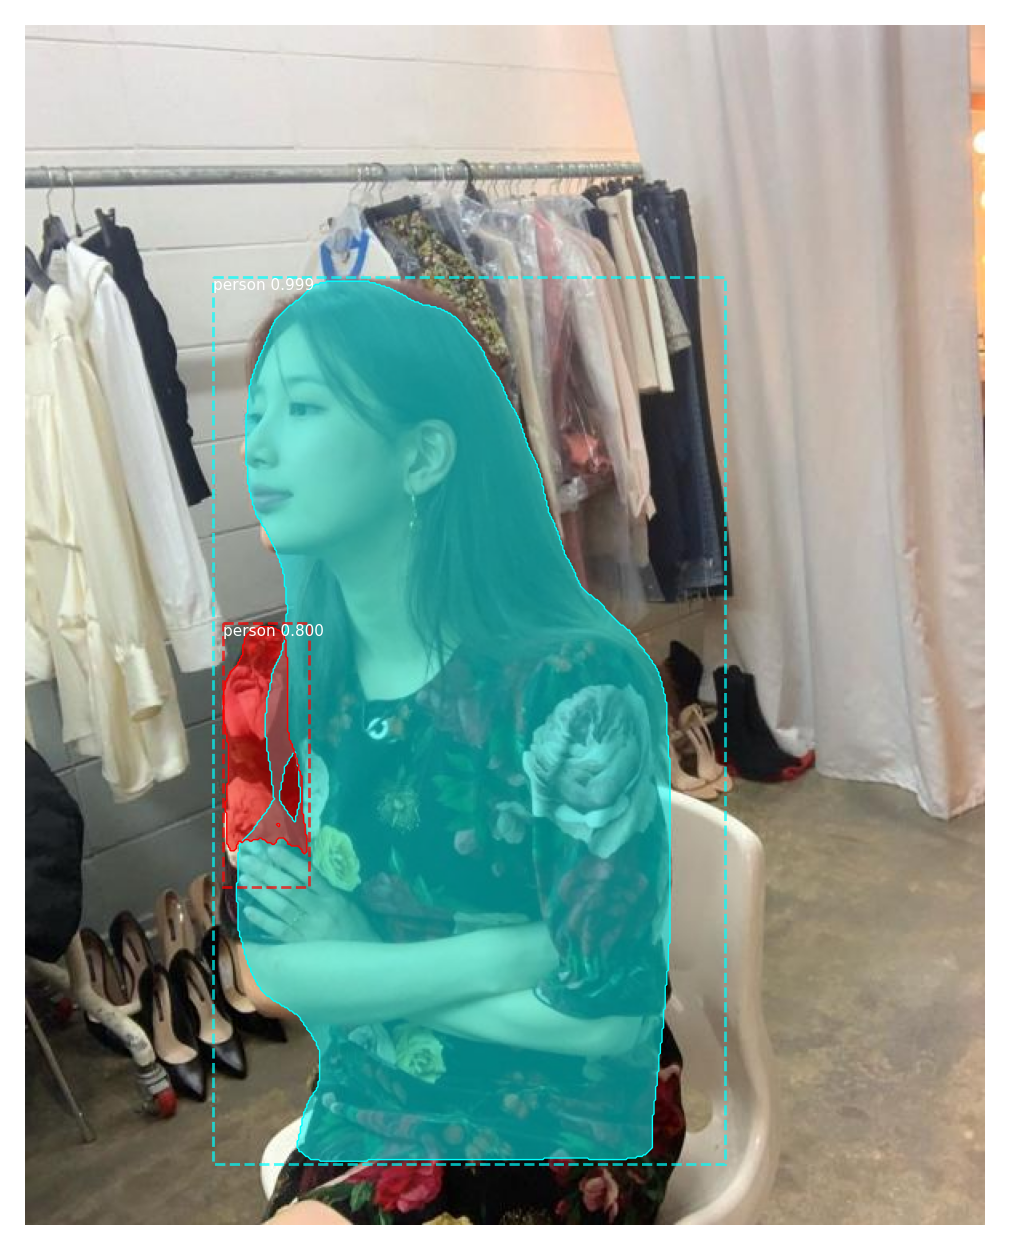

In [6]:

file_name='face_model/output/suji2.jpg'
image = skimage.io.imread(os.path.join(file_name))

results= model.detect([image],verbose=0)
r = results[0]
visualize.display_instances(image, r['rois'],r['masks'],r['class_ids'], class_names, r['scores'])


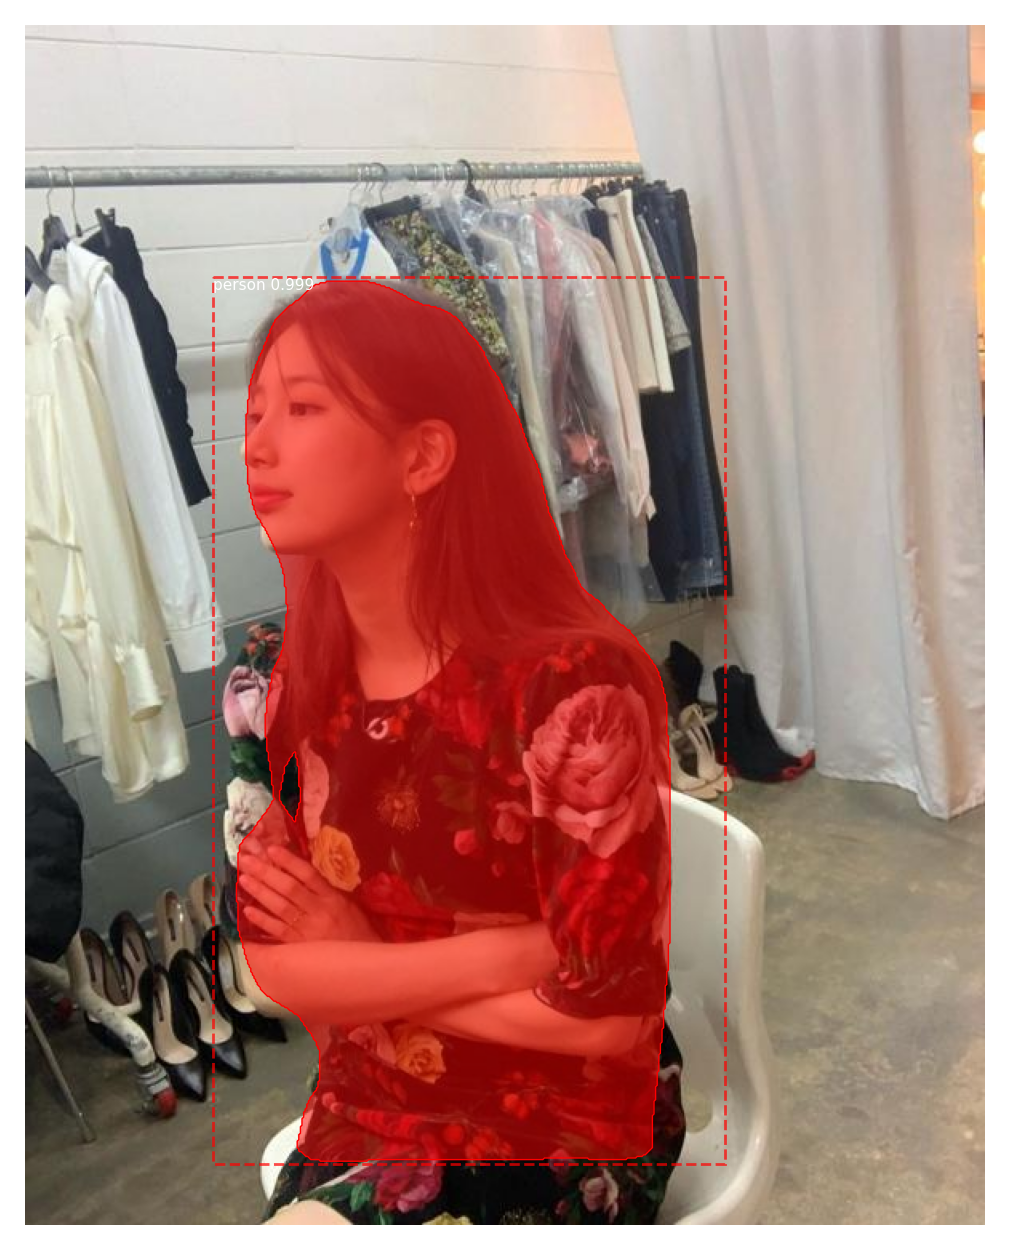

In [7]:

# 임계값 설정
threshold = 0.9

indices_to_keep = np.where(r['scores'] > threshold)[0]

# 선택한 인덱스에 해당하는 masks, scores, class_ids를 가져옵니다.
r['masks'] = r['masks'][:, :, indices_to_keep]
r['scores'] = r['scores'][indices_to_keep]
r['class_ids'] = r['class_ids'][indices_to_keep]
r['rois'] = r['rois'][indices_to_keep]

visualize.display_instances(image, r['rois'],r['masks'],r['class_ids'], class_names, r['scores'])


In [8]:
masks = r['masks'][:, :, r['class_ids'] == 1]  # 사람인 경우
mask = np.sum(masks, axis=2).astype(np.bool)  # 채널 하나짜리 마스크

kernel = np.ones((25, 25), np.uint8)  # 팽창 연산에 사용될 커널 설정
expanded_mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
expanded_mask = expanded_mask.astype(np.bool)

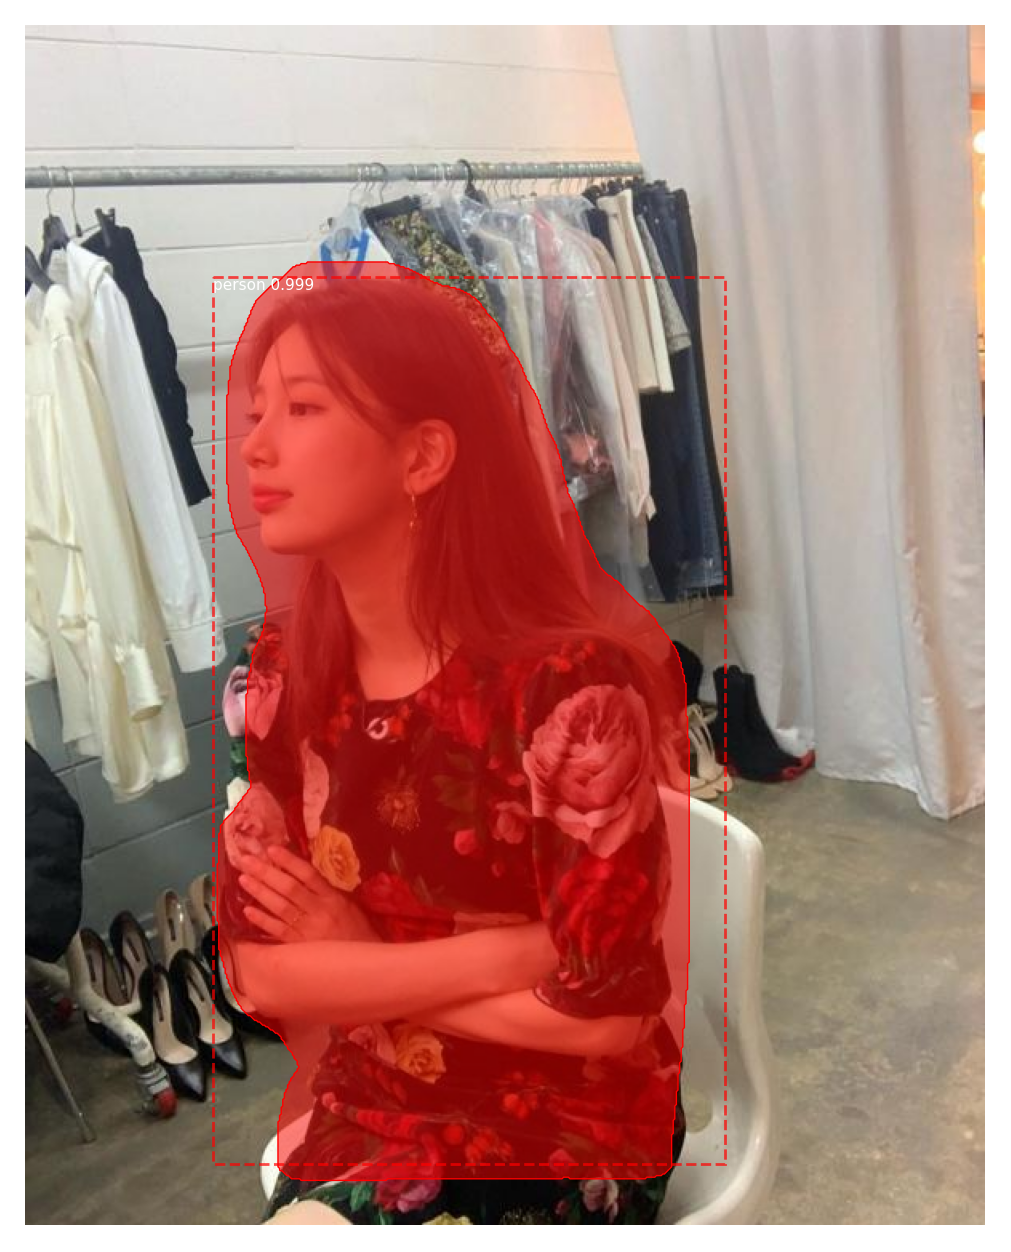

In [9]:
exp_mask = expanded_mask[:, :, np.newaxis]
visualize.display_instances(image, r['rois'],exp_mask ,r['class_ids'], class_names, r['scores'])

In [10]:

# 확장된 마스크 생성
kernel = np.ones((25, 25), np.uint8)  # 팽창 연산에 사용될 커널 설정
expanded_mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
expanded_mask = expanded_mask.astype(np.bool)
mask_3d = np.repeat(np.expand_dims(expanded_mask, axis=2), 3, axis=2).astype(np.uint8)  # 채널 3


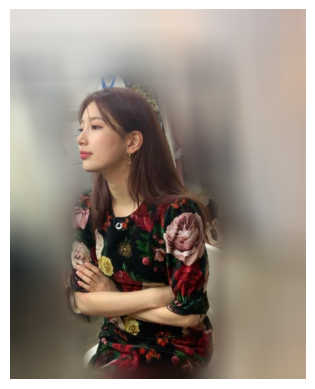

In [11]:
import matplotlib.pyplot as plt
# 블러 처리
blurred_img = cv2.GaussianBlur(image, (101, 101), 125)
mask_3d_blurred = (cv2.GaussianBlur(mask_3d*255,(101,101),10,10)/255).astype(np.float32)

# mix it together
person_mask = mask_3d_blurred * image.astype(np.float32)
bg_mask = (1 - mask_3d_blurred) * blurred_img.astype(np.float32)
out = (person_mask + bg_mask).astype(np.uint8)
out_image = out.astype(np.uint8)
plt.axis('off')
plt.imshow(out_image)

In [21]:
person_mask = mask_3d_blurred * image.astype(np.float32)
bg_mask = (1 - mask_3d_blurred) * blurred_img.astype(np.float32)
out = (person_mask + bg_mask).astype(np.uint8)
out_image = out.astype(np.uint8)

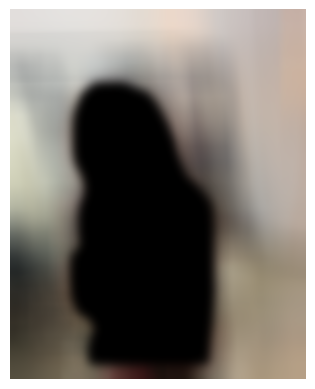

In [20]:
plt.axis('off')
plt.imshow(bg_mask.astype(np.uint8))


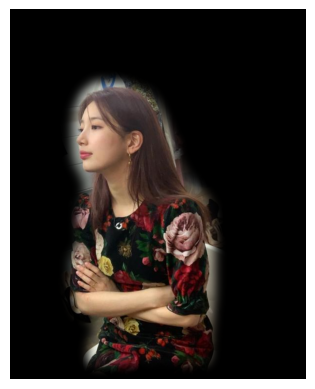

In [19]:
plt.axis('off')
plt.imshow(person_mask.astype(np.uint8))




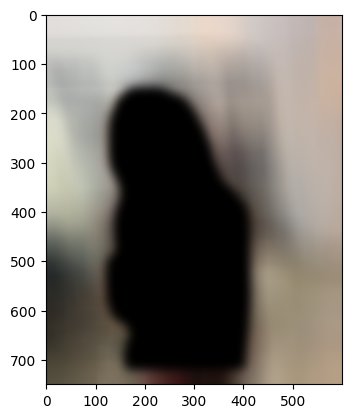

In [61]:
plt.imshow(bg_mask.astype(np.uint8))

In [ ]:

masks = r['masks'][:, :, r['class_ids'] == 1]  # 사람인 경우

if not masks.size > 0:
    print('NO person!!')
    out_list.append(file_name)
else:
    mask = np.sum(masks, axis=2).astype(np.bool)  # 채널 하나짜리 마스크
    
    # 확장된 마스크 생성
    kernel = np.ones((25, 25), np.uint8)  # 팽창 연산에 사용될 커널 설정
    expanded_mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
    expanded_mask = expanded_mask.astype(np.bool)
    mask_3d = np.repeat(np.expand_dims(expanded_mask, axis=2), 3, axis=2).astype(np.uint8)  # 채널 3

    # 이미지 블러 처리
    blurred_img = cv2.GaussianBlur(image, (101, 101), 125)
    mask_3d_blurred = (cv2.GaussianBlur(mask_3d*255,(101,101),10,10)/255).astype(np.float32)

    # mix it together
    person_mask = mask_3d_blurred * image.astype(np.float32)
    bg_mask = (1 - mask_3d_blurred) * blurred_img.astype(np.float32)
    out = (person_mask + bg_mask).astype(np.uint8)
    out_image = out.astype(np.uint8)
    
    bgr_image = cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR) # 최종본!
    print(file_name, 'finish!') # 잘되는지 안되는지 확인
    
    #img_name = 'img'+ str(NUM) + '.jpg'
    #output_path = os.path.join(input, img_name) #위에서 정의한 경로에 filname으로 저장하기 위한 코드
    bgr_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 8))  # figure 크기를 이미지 크기와 일치시킴
    plt.axis('off')
    plt.imshow(bgr_image)


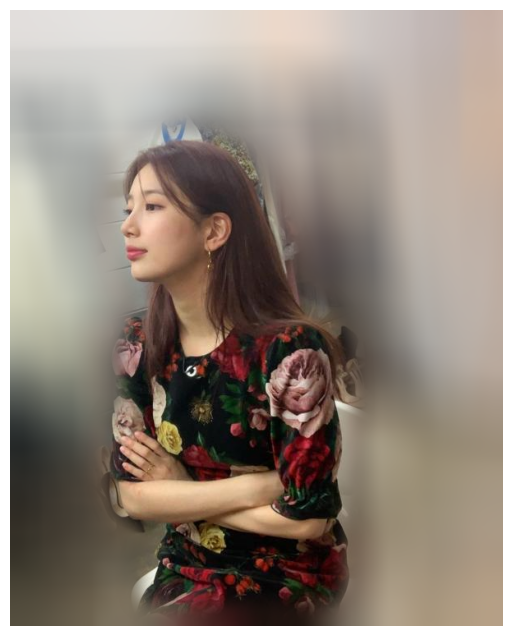

In [29]:
# bgr_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))  # figure 크기를 이미지 크기와 일치시킴
plt.axis('off')
plt.imshow(out_image)

In [ ]:

masks = r['masks'][:, :, r['class_ids'] == 1]  # 사람인 경우

if not masks.size > 0:
    print('NO person!!')
    out_list.append(file_name)
else:
    mask = np.sum(masks, axis=2).astype(np.bool)  # 채널 하나짜리 마스크
    # 확장된 마스크 생성
    kernel = np.ones((11, 11), np.uint8)  # 팽창 연산에 사용될 커널 설정
    expanded_mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
    expanded_mask = expanded_mask.astype(np.bool)
    mask_3d = np.repeat(np.expand_dims(expanded_mask, axis=2), 3, axis=2).astype(np.uint8)  # 채널 3짜리 마스크

    # 이미지 블러 처리
    blurred_img = cv2.GaussianBlur(image, (101, 101), 125)
    mask_3d_blurred = (cv2.GaussianBlur(mask_3d*255,(101,101),10,10)/255).astype(np.float32)

    # mix it together
    person_mask = mask_3d_blurred * image.astype(np.float32)
    bg_mask = (1 - mask_3d_blurred) * blurred_img.astype(np.float32)
    out = (person_mask + bg_mask).astype(np.uint8)
    out_image = out.astype(np.uint8)
    
    bgr_image = cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR) # 최종본!
    print(file_name, 'finish!') # 잘되는지 안되는지 확인
    
    #img_name = 'img'+ str(NUM) + '.jpg'
    #output_path = os.path.join(input, img_name) #위에서 정의한 경로에 filname으로 저장하기 위한 코드
    bgr_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 8))  # figure 크기를 이미지 크기와 일치시킴
    plt.axis('off')
    plt.imshow(bgr_image)


In [ ]:
###이어서!!!!!!!!!!!!!!!

# file_name='face_model/output/suji2.jpg'
# image = skimage.io.imread(os.path.join(file_name))

results= model.detect([image_rgb],verbose=0)
r = results[0]
# visualize.display_instances(image_rgb, r['rois'],r['masks'],r['class_ids'], class_names, r['scores'])

# 임계값 설정
threshold = 0.8

indices_to_keep = np.where(r['scores'] > threshold)[0]

# 선택한 인덱스에 해당하는 masks, scores, class_ids를 가져옵니다.
r['masks'] = r['masks'][:, :, indices_to_keep]
r['scores'] = r['scores'][indices_to_keep]
r['class_ids'] = r['class_ids'][indices_to_keep]

masks = r['masks'][:, :, r['class_ids'] == 1]  # 사람인 경우

if not masks.size > 0:
    print('NO person!!')
    out_list.append(file_name)
else:
    mask = np.sum(masks, axis=2).astype(np.bool)  # 채널 하나짜리 마스크
    # 확장된 마스크 생성
    kernel = np.ones((11, 11), np.uint8)  # 팽창 연산에 사용될 커널 설정
    expanded_mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
    expanded_mask = expanded_mask.astype(np.bool)
    mask_3d = np.repeat(np.expand_dims(expanded_mask, axis=2), 3, axis=2).astype(np.uint8)  # 채널 3짜리 마스크

    # 이미지 블러 처리
    blurred_img = cv2.GaussianBlur(image_rgb, (101, 101), 125)
    mask_3d_blurred = (cv2.GaussianBlur(mask_3d*255,(101,101),10,10)/255).astype(np.float32)

    # mix it together
    person_mask = mask_3d_blurred * image_rgb.astype(np.float32)
    bg_mask = (1 - mask_3d_blurred) * blurred_img.astype(np.float32)
    out = (person_mask + bg_mask).astype(np.uint8)
    out_image = out.astype(np.uint8)
    
    bgr_image = cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR) # 최종본!
    print(file_name, 'finish!') # 잘되는지 안되는지 확인
    
    #img_name = 'img'+ str(NUM) + '.jpg'
    #output_path = os.path.join(input, img_name) #위에서 정의한 경로에 filname으로 저장하기 위한 코드
    bgr_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 8))  # figure 크기를 이미지 크기와 일치시킴
    plt.axis('off')
    plt.imshow(bgr_image)
